In [117]:
# Step 1: Setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For time stamps
from datetime import datetime


In [118]:
def load_asc_files(folder_path, columns):
    data = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.asc'):
            # Extract company name from filename (without extension) and avoid the last two characters
            company_name = os.path.splitext(filename)[0][:-2]  # Exclude the last two characters
            
            # Load the data
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, header=None, names=columns)
            
            # Add a new column for the company name
            df['Company'] = company_name
            
            # Append to the list
            data.append(df)
    
    # Concatenate all DataFrames into one
    return pd.concat(data, ignore_index=True)

In [119]:
# Step 2: Load Data
trade_folder = r"C:\Users\Shivay\OneDrive\Desktop\stock_market\2024_04_01_T"
quote_folder = r"C:\Users\Shivay\OneDrive\Desktop\stock_market\2024_04_01_Q"

trade_columns = ['Date', 'Time', 'Price', 'Volume', 'Aggressor Side', 'Trade Period', 
                 'Trade ID', 'Buyer', 'Buy Algo Type', 'Buy Order Capacity', 
                 'Seller', 'Sell Algo Type', 'Sell Order Capacity']
 
quote_columns = ['Date', 'Time', 'Bid Price', 'Bid Size', 'Ask Price', 'Ask Size']

quote_data = load_asc_files(quote_folder, quote_columns)
trade_data = load_asc_files(trade_folder, trade_columns)

In [120]:
# Step 3: Preprocess Data
# Preprocessing; convert date time
def convert_to_minute(df):
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df['Minute'] = df['Datetime'].dt.floor('min')  # Truncate to minute
    return df

trade_data = convert_to_minute(trade_data)
quote_data = convert_to_minute(quote_data)

In [121]:
# Aggregate data at minute level
trade_agg = trade_data.groupby(['Minute', 'Company']).agg(
    num_trades=('Trade ID', 'count'),
    Open=('Price', 'first'),
    High=('Price', 'max'),
    Low=('Price', 'min'),
    Close=('Price', 'last'),
    total_volume=('Volume', 'sum'),
    total_buy_cap=('Buy Order Capacity', 'sum'),
    total_sell_cap=('Sell Order Capacity', 'sum'),
    trade_period=('Trade Period', lambda x: x.mode()[0]),  # Mode for trade period
    weighted_price=('Price', lambda x: np.average(x, weights=trade_data.loc[x.index, 'Volume'])),
    trade_imbalance_ratio=('Aggressor Side', lambda x: 
        (x == 'B').sum() / (x == 'S').sum() if (x == 'S').sum() > 0 else 0),
    trade_volume_imbalance_ratio=('Volume', lambda x: 
        trade_data.loc[x.index, 'Volume'][trade_data.loc[x.index, 'Aggressor Side'] == 'B'].sum() /
        trade_data.loc[x.index, 'Volume'][trade_data.loc[x.index, 'Aggressor Side'] == 'S'].sum() 
        if trade_data.loc[x.index, 'Volume'][trade_data.loc[x.index, 'Aggressor Side'] == 'S'].sum() > 0 else 0),
    order_cap_imbalnce_ratio=('Sell Order Capacity', lambda x: 
        (trade_data.loc[x.index, 'Sell Order Capacity'] != trade_data.loc[x.index, 'Sell Order Capacity']).sum() / len(x))
).reset_index()

In [122]:
trade_agg

,Minute,Company,num_trades,Open,High,Low,Close,total_volume,total_buy_cap,total_sell_cap,trade_period,weighted_price,trade_imbalance_ratio,trade_volume_imbalance_ratio,order_cap_imbalnce_ratio
0,2024-04-01 09:07:00,ADANIENT_2024_04_01,386,3230.20,3230.20,3230.20,3230.20,6720,1113,1005,O,3230.20,0.0,0.0,0.0
1,2024-04-01 09:07:00,ADANIPORTS_2024_04_01,547,1356.80,1356.80,1356.80,1356.80,17367,1523,1436,O,1356.80,0.0,0.0,0.0
2,2024-04-01 09:07:00,APOLLOHOSP_2024_04_01,134,6401.00,6401.00,6401.00,6401.00,669,275,374,O,6401.00,0.0,0.0,0.0
3,2024-04-01 09:07:00,ASIANPAINT_2024_04_01,413,2860.95,2860.95,2860.95,2860.95,3740,1029,1125,O,2860.95,0.0,0.0,0.0
4,2024-04-01 09:07:00,AXISBANK_2024_04_01,257,1052.35,1052.35,1052.35,1052.35,19250,679,482,O,1052.35,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11889,2024-04-01 15:58:00,HEROMOTOCO_2024_04_01,1,4680.75,4680.75,4680.75,4680.75,1,3,3,T,4680.75,0.0,0.0,0.0
11890,2024-04-01 15:58:00,INFY_2024_04_01,1,1495.45,1495.45,1495.45,1495.45,15,3,3,T,1495.45,0.0,0.0,0.0
11891,2024-04-01 15:58:00,TITAN_2024_04_01,1,3738.40,3738.40,3738.40,3738.40,3,3,3,T,3738.40,0.0,0.0,0.0
11892,2024-04-01 15:59:00,ITC_2024_04_01,1,426.70,426.70,426.70,426.70,10,3,3,T,426.70,0.0,0.0,0.0


In [123]:
# Aggregate quote data at the minute level
quote_agg = quote_data.groupby(['Minute', 'Company']).agg(
    avg_spread=('Bid Price', lambda x: np.mean((quote_data.loc[x.index, 'Ask Price'] - x).fillna(0))),
    max_spread=('Bid Price', lambda x: np.max((quote_data.loc[x.index, 'Ask Price'] - x).fillna(0))),
    min_spread=('Bid Price', lambda x: np.min((quote_data.loc[x.index, 'Ask Price'] - x).fillna(0))),
    total_bid_size=('Bid Size', 'sum'),
    total_ask_size=('Ask Size', 'sum'),
    
    # Weighted average bid and ask prices
    weighted_avg_bid_price=('Bid Price', lambda x: np.average(x, weights=quote_data.loc[x.index, 'Bid Size'].fillna(1))),
    weighted_avg_ask_price=('Ask Price', lambda x: np.average(x, weights=quote_data.loc[x.index, 'Ask Size'].fillna(1)))
).reset_index().fillna(0)


In [124]:
quote_agg

,Minute,Company,avg_spread,max_spread,min_spread,total_bid_size,total_ask_size,weighted_avg_bid_price,weighted_avg_ask_price
0,2024-04-01 09:00:00,ADANIENT_2024_04_01,-80.887500,30.00,-336.90,202,710,3218.981188,0.000000
1,2024-04-01 09:00:00,ADANIPORTS_2024_04_01,-103.750000,0.00,-167.70,2094,3806,0.000000,1337.366290
2,2024-04-01 09:00:00,APOLLOHOSP_2024_04_01,-304.245000,163.95,-762.75,643,507,6434.798834,0.000000
3,2024-04-01 09:00:00,ASIANPAINT_2024_04_01,-195.934091,174.15,-427.00,1326,2400,3028.420852,0.000000
4,2024-04-01 09:00:00,AXISBANK_2024_04_01,-58.983333,94.90,-162.10,228,8928,0.000000,987.439992
...,...,...,...,...,...,...,...,...,...
11806,2024-04-01 15:54:00,HCLTECH_2024_04_01,2.000000,2.00,2.00,58,629,1558.000000,1560.000000
11807,2024-04-01 15:56:00,BPCL_2024_04_01,0.500000,0.50,0.50,1580,423,602.000000,602.500000
11808,2024-04-01 15:56:00,HEROMOTOCO_2024_04_01,9.000000,9.00,9.00,5,72,4690.000000,4699.000000
11809,2024-04-01 15:57:00,ITC_2024_04_01,0.100000,0.10,0.10,17860,1400,427.500000,427.600000


In [125]:
# Step 4: Merge and Feature Engineering
combined_data = pd.merge(trade_agg, quote_agg, on=['Minute', 'Company'])

In [126]:
combined_data

,Minute,Company,num_trades,Open,High,Low,Close,total_volume,total_buy_cap,total_sell_cap,...,trade_imbalance_ratio,trade_volume_imbalance_ratio,order_cap_imbalnce_ratio,avg_spread,max_spread,min_spread,total_bid_size,total_ask_size,weighted_avg_bid_price,weighted_avg_ask_price
0,2024-04-01 09:07:00,ADANIENT_2024_04_01,386,3230.20,3230.20,3230.20,3230.20,6720,1113,1005,...,0.000000,0.000000,0.0,-81.331402,1.00,-638.60,76268,128052,3258.433120,3214.149230
1,2024-04-01 09:07:00,ADANIPORTS_2024_04_01,547,1356.80,1356.80,1356.80,1356.80,17367,1523,1436,...,0.000000,0.000000,0.0,-28.452658,2.10,-262.30,328779,622512,1363.692199,1345.868445
2,2024-04-01 09:07:00,APOLLOHOSP_2024_04_01,134,6401.00,6401.00,6401.00,6401.00,669,275,374,...,0.000000,0.000000,0.0,-213.074272,4.80,-794.60,4315,6506,6593.837601,6311.395489
3,2024-04-01 09:07:00,ASIANPAINT_2024_04_01,413,2860.95,2860.95,2860.95,2860.95,3740,1029,1125,...,0.000000,0.000000,0.0,-133.111386,0.90,-427.00,95408,55572,2981.080010,2831.588966
4,2024-04-01 09:07:00,AXISBANK_2024_04_01,257,1052.35,1052.35,1052.35,1052.35,19250,679,482,...,0.000000,0.000000,0.0,-39.415396,0.25,-162.10,319318,669459,1052.886235,994.583352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11663,2024-04-01 15:42:00,INFY_2024_04_01,4,1495.45,1495.45,1495.45,1495.45,51,12,12,...,0.000000,0.000000,0.0,0.500000,0.50,0.50,386,67,1497.000000,1497.500000
11664,2024-04-01 15:45:00,ADANIPORTS_2024_04_01,4,1375.90,1375.90,1375.90,1375.90,63,8,12,...,0.000000,0.000000,0.0,1.500000,1.50,1.50,3895,1,1378.000000,1379.500000
11665,2024-04-01 15:48:00,BPCL_2024_04_01,5,600.70,600.70,600.70,600.70,45,15,15,...,0.666667,0.097561,0.0,0.500000,0.50,0.50,1680,423,602.000000,602.500000
11666,2024-04-01 15:50:00,CIPLA_2024_04_01,1,1498.65,1498.65,1498.65,1498.65,22,1,3,...,0.000000,0.000000,0.0,4.500000,4.50,4.50,1,993,1496.500000,1501.000000


In [127]:
#compute 1-minute stock return

combined_data['Return'] = combined_data.groupby('Company')['Close'].shift(-1) / combined_data['Close'] - 1
combined_data.dropna(inplace=True)

In [128]:
combined_data

,Minute,Company,num_trades,Open,High,Low,Close,total_volume,total_buy_cap,total_sell_cap,...,trade_volume_imbalance_ratio,order_cap_imbalnce_ratio,avg_spread,max_spread,min_spread,total_bid_size,total_ask_size,weighted_avg_bid_price,weighted_avg_ask_price,Return
0,2024-04-01 09:07:00,ADANIENT_2024_04_01,386,3230.20,3230.20,3230.20,3230.20,6720,1113,1005,...,0.000000,0.0,-81.331402,1.00,-638.60,76268,128052,3258.433120,3214.149230,0.003266
1,2024-04-01 09:07:00,ADANIPORTS_2024_04_01,547,1356.80,1356.80,1356.80,1356.80,17367,1523,1436,...,0.000000,0.0,-28.452658,2.10,-262.30,328779,622512,1363.692199,1345.868445,0.001916
2,2024-04-01 09:07:00,APOLLOHOSP_2024_04_01,134,6401.00,6401.00,6401.00,6401.00,669,275,374,...,0.000000,0.0,-213.074272,4.80,-794.60,4315,6506,6593.837601,6311.395489,-0.001390
3,2024-04-01 09:07:00,ASIANPAINT_2024_04_01,413,2860.95,2860.95,2860.95,2860.95,3740,1029,1125,...,0.000000,0.0,-133.111386,0.90,-427.00,95408,55572,2981.080010,2831.588966,-0.000472
4,2024-04-01 09:07:00,AXISBANK_2024_04_01,257,1052.35,1052.35,1052.35,1052.35,19250,679,482,...,0.000000,0.0,-39.415396,0.25,-162.10,319318,669459,1052.886235,994.583352,-0.000855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11648,2024-04-01 15:29:00,ICICIBANK_2024_04_01,667,1099.15,1101.00,1097.00,1098.70,186888,1456,1097,...,1.490479,0.0,0.453377,2.35,0.05,758868,11655899,1098.252228,1098.098816,0.000865
11650,2024-04-01 15:29:00,INFY_2024_04_01,1061,1497.00,1498.00,1496.85,1497.50,30471,2888,2142,...,1.359350,0.0,0.218625,1.00,0.05,419736,300563,1497.200232,1497.540925,-0.001369
11653,2024-04-01 15:29:00,KOTAKBANK_2024_04_01,140,1788.85,1790.00,1788.00,1790.00,4328,322,309,...,0.519663,0.0,0.581541,1.30,0.05,51845,46594,1788.772717,1789.770387,0.000391
11655,2024-04-01 15:29:00,TITAN_2024_04_01,281,3742.20,3750.00,3742.00,3745.95,6041,763,786,...,2.322882,0.0,1.036301,6.00,0.05,41387,49857,3743.193430,3744.452245,-0.002016


In [129]:
print(combined_data.columns)

Index(['Minute', 'Company', 'num_trades', 'Open', 'High', 'Low', 'Close',
       'total_volume', 'total_buy_cap', 'total_sell_cap', 'trade_period',
       'weighted_price', 'trade_imbalance_ratio',
       'trade_volume_imbalance_ratio', 'order_cap_imbalnce_ratio',
       'avg_spread', 'max_spread', 'min_spread', 'total_bid_size',
       'total_ask_size', 'weighted_avg_bid_price', 'weighted_avg_ask_price',
       'Return'],
      dtype='object')


In [130]:
# Step 5: Train-Test Split
split_index = int(0.8 * len(combined_data))
train_data = combined_data[:split_index]
test_data = combined_data[split_index:]

In [131]:
print(train_data.columns)


Index(['Minute', 'Company', 'num_trades', 'Open', 'High', 'Low', 'Close',
       'total_volume', 'total_buy_cap', 'total_sell_cap', 'trade_period',
       'weighted_price', 'trade_imbalance_ratio',
       'trade_volume_imbalance_ratio', 'order_cap_imbalnce_ratio',
       'avg_spread', 'max_spread', 'min_spread', 'total_bid_size',
       'total_ask_size', 'weighted_avg_bid_price', 'weighted_avg_ask_price',
       'Return'],
      dtype='object')


In [132]:
print([col for col in train_data.columns if 'order_cap' in col.lower()])


['order_cap_imbalnce_ratio']


In [133]:
# Step 6: Select features for linear regression
features = ['num_trades', 'Open', 'High', 'Low', 'Close', 'total_volume', 
            'total_buy_cap', 'total_sell_cap', 'trade_imbalance_ratio', 
            'trade_volume_imbalance_ratio', 'order_cap_imbalnce_ratio', 
            'avg_spread', 'max_spread', 'min_spread', 'total_bid_size', 
            'total_ask_size', 'weighted_avg_bid_price', 'weighted_avg_ask_price']

X_train, y_train = train_data[features], train_data['Return']
X_test, y_test = test_data[features], test_data['Return']

#Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Fit the model for each company
results = {}
for company in train_data['Company'].unique():
    company_train_data = train_data[train_data['Company'] == company]
    model.fit(company_train_data[features], company_train_data['Return'])
    # Store the model or results
    results[company] = model

# Predictions
test_data['Predicted Return'] = np.nan
for company in test_data['Company'].unique():
    company_test_data = test_data[test_data['Company'] == company]
    test_data.loc[test_data['Company'] == company, 'Predicted Return'] = model.predict(company_test_data[features])

C:\Users\Shivay\AppData\Local\Temp\ipykernel_6068\1064260999.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Return'] = np.nan


In [134]:
# Step 7: Model Evaluation
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

mse_dict = {}
for company in test_data['Company'].unique():
    company_test_data = test_data[test_data['Company'] == company]
    mse = mean_squared_error(company_test_data['Return'], company_test_data['Predicted Return'])
    mse_dict[company] = mse

# Print MSE values in a more readable format with an index
print("Mean Squared Error by Company:")
for index, (company, mse) in enumerate(mse_dict.items(), start=1):
    print(f"{index}. {company}: {mse:.4f}")  # Format to 4 decimal places for better readability

R² Score: -470.5837
Mean Squared Error by Company:
1. BPCL_2024_04_01: 0.0003
2. BRITANNIA_2024_04_01: 0.0000
3. CIPLA_2024_04_01: 0.0001
4. COALINDIA_2024_04_01: 0.0003
5. DIVISLAB_2024_04_01: 0.0000
6. DRREDDY_2024_04_01: 0.0001
7. EICHERMOT_2024_04_01: 0.0000
8. GRASIM_2024_04_01: 0.0001
9. HCLTECH_2024_04_01: 0.0001
10. HDFCBANK_2024_04_01: 0.0002
11. HDFCLIFE_2024_04_01: 0.0003
12. HEROMOTOCO_2024_04_01: 0.0000
13. HINDALCO_2024_04_01: 0.0003
14. HINDUNILVR_2024_04_01: 0.0001
15. ICICIBANK_2024_04_01: 0.0002
16. INDUSINDBK_2024_04_01: 0.0001
17. INFY_2024_04_01: 0.0001
18. ITC_2024_04_01: 0.0003
19. JSWSTEEL_2024_04_01: 0.0002
20. KOTAKBANK_2024_04_01: 0.0001
21. TCS_2024_04_01: 0.0000
22. TITAN_2024_04_01: 0.0000
23. ADANIENT_2024_04_01: 0.0000
24. ADANIPORTS_2024_04_01: 0.0001
25. APOLLOHOSP_2024_04_01: 0.0002
26. ASIANPAINT_2024_04_01: 0.0000
27. AXISBANK_2024_04_01: 0.0002
28. BAJAJ-AUTO_2024_04_01: 0.0007
29. BAJAJFINSV_2024_04_01: 0.0001
30. BAJFINANCE_2024_04_01: 0.0003
31.

In [135]:
# Step 8: Correlation Analysis

# Create a pivot table to calculate the average correlation across companies per minute
pivoted_data = test_data.pivot_table(index='Minute', columns='Company', values='Return')
correlation_per_minute = pivoted_data.corr().mean(axis=1)

correlation_per_minute

Company
ADANIENT_2024_04_01      0.161589
ADANIPORTS_2024_04_01    0.161365
APOLLOHOSP_2024_04_01    0.070211
ASIANPAINT_2024_04_01    0.131269
AXISBANK_2024_04_01      0.175330
BAJAJ-AUTO_2024_04_01    0.107583
BAJAJFINSV_2024_04_01    0.119285
BAJFINANCE_2024_04_01    0.151489
BHARTIARTL_2024_04_01    0.101281
BPCL_2024_04_01          0.144323
BRITANNIA_2024_04_01     0.178505
CIPLA_2024_04_01         0.075679
COALINDIA_2024_04_01     0.179625
DIVISLAB_2024_04_01      0.115314
DRREDDY_2024_04_01       0.075833
EICHERMOT_2024_04_01     0.143944
GRASIM_2024_04_01        0.115173
HCLTECH_2024_04_01       0.129407
HDFCBANK_2024_04_01      0.060567
HDFCLIFE_2024_04_01     -0.014915
HEROMOTOCO_2024_04_01    0.144205
HINDALCO_2024_04_01      0.145815
HINDUNILVR_2024_04_01    0.159292
ICICIBANK_2024_04_01     0.078466
INDUSINDBK_2024_04_01    0.132235
INFY_2024_04_01          0.117521
ITC_2024_04_01           0.126737
JSWSTEEL_2024_04_01      0.138185
KOTAKBANK_2024_04_01    -0.025948
TCS_20

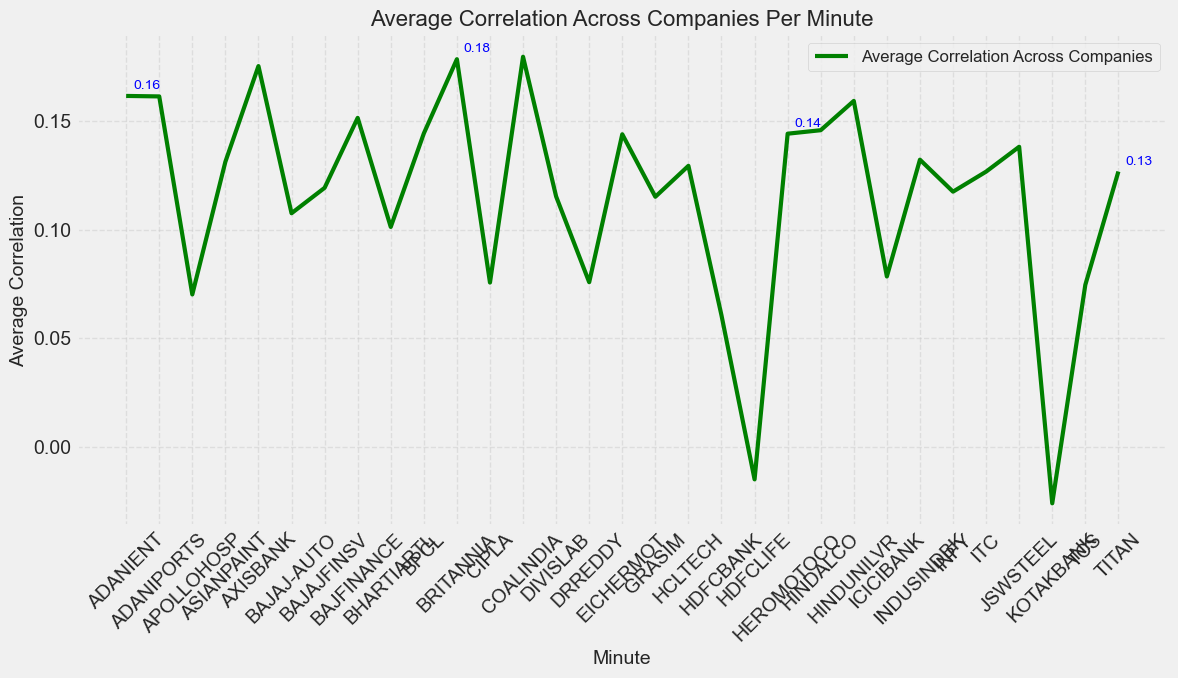

In [142]:
# Ensure company names in correlation_per_minute are cleaned
correlation_per_minute.index = correlation_per_minute.index.str.split('_').str[0]

# Create the plot
plt.figure(figsize=(12, 7))
plt.plot(correlation_per_minute.index, correlation_per_minute.values, label='Average Correlation Across Companies', color='green', linewidth=3)

# Annotate key points
for i, (x, y) in enumerate(zip(correlation_per_minute.index, correlation_per_minute.values)):
    if i % 10 == 0:  # Adjust frequency of annotations
        plt.annotate(f"{y:.2f}", xy=(x, y), xytext=(5, 5), textcoords='offset points', fontsize=10, color='blue')

# Enhance the appearance of the plot
plt.xlabel('Minute', fontsize=14)
plt.ylabel('Average Correlation', fontsize=14)
plt.title('Average Correlation Across Companies Per Minute', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Add a grid with a specific style
plt.legend(fontsize=12)
plt.tight_layout()  # Adjust layout for better spacing

# Show the plot
plt.show()


Average Correlation: 0.1162


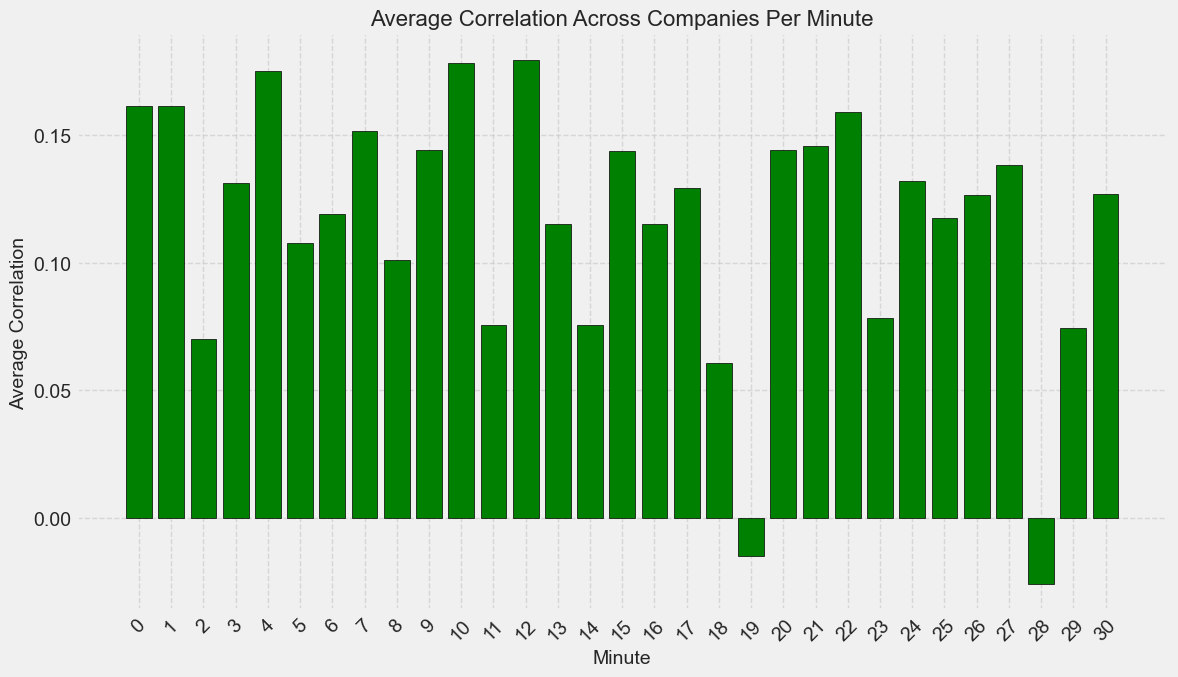

In [144]:
# Calculate the average correlation for each minute
average_correlation = correlation_per_minute.mean()  # No axis argument needed

# Print average correlation
print(f"Average Correlation: {average_correlation:.4f}")

# Optional: Create a bar plot for average correlation
plt.figure(figsize=(12, 7))
plt.bar(range(len(correlation_per_minute)), correlation_per_minute.values, color='green', edgecolor='black')

# Enhance the appearance of the bar plot
plt.xlabel('Minute', fontsize=14)
plt.ylabel('Average Correlation', fontsize=14)
plt.title('Average Correlation Across Companies Per Minute', fontsize=16)
plt.xticks(range(len(correlation_per_minute)), rotation=45)  
plt.grid(visible=True, linestyle='--', alpha=0.7)  

# Show the plot
plt.tight_layout()
plt.show()

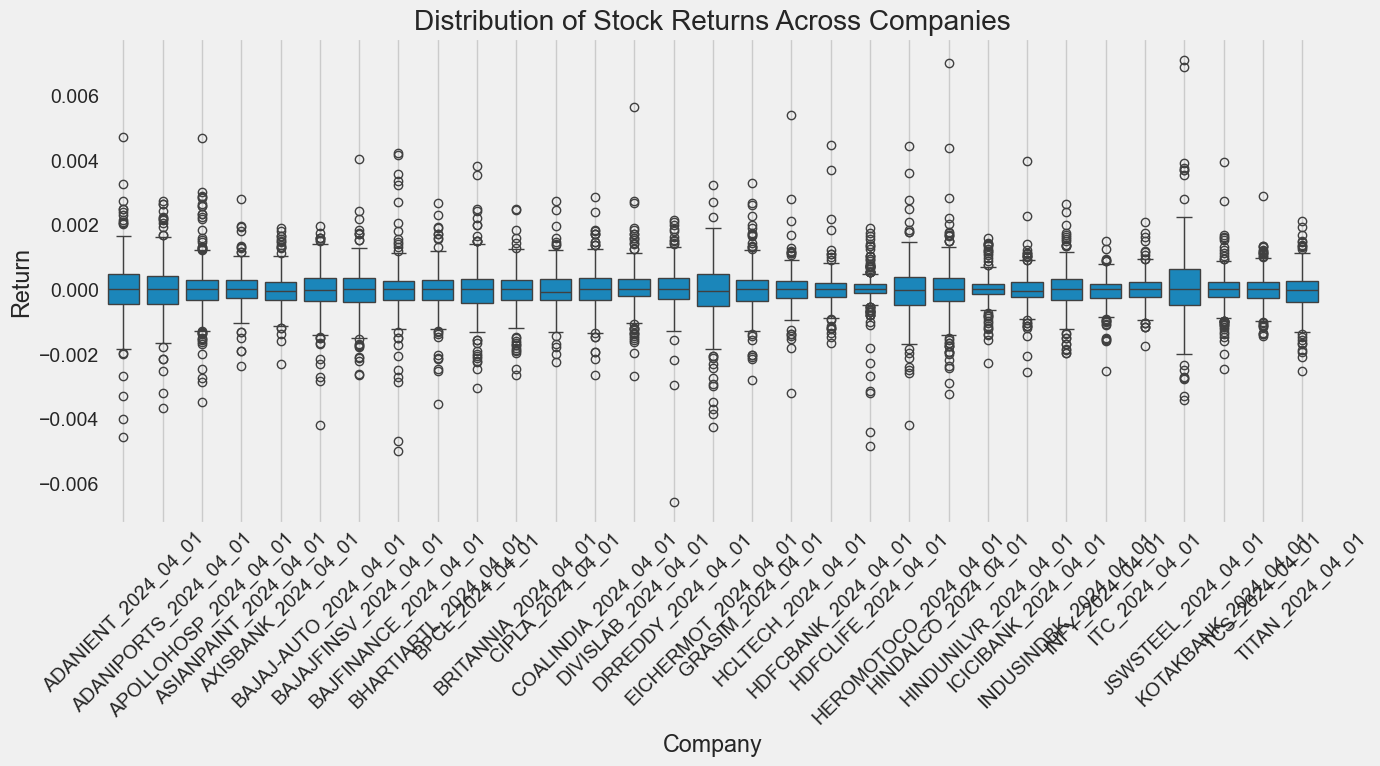

In [154]:

plt.figure(figsize=(14, 6))
sns.boxplot(x='Company', y='Return', data=train_data)
plt.xticks(rotation=45)
plt.title('Distribution of Stock Returns Across Companies')
plt.xlabel('Company')
plt.ylabel('Return')
plt.grid()
plt.show()


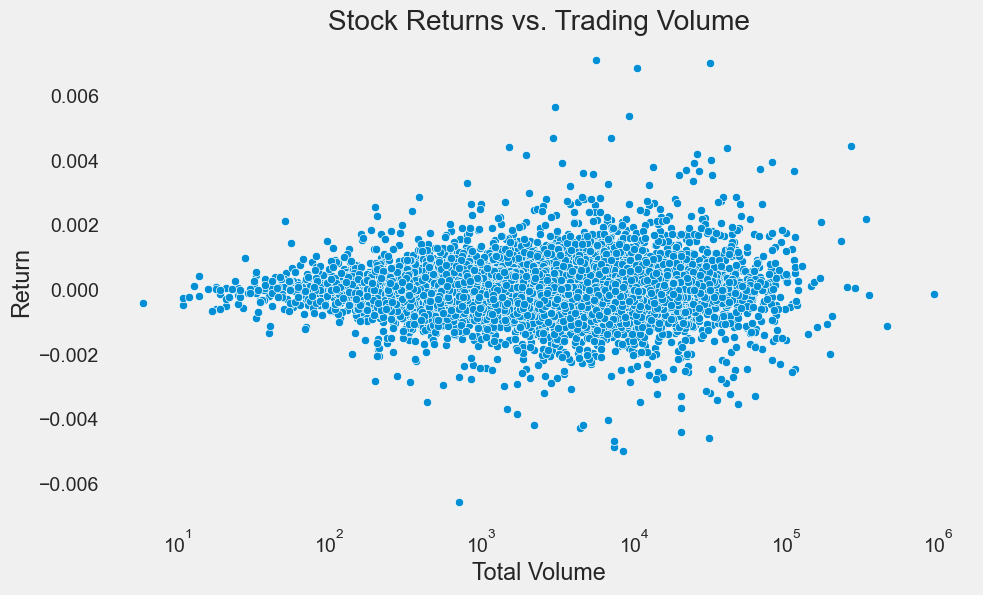

In [156]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['total_volume'], y=train_data['Return'])
plt.title('Stock Returns vs. Trading Volume')
plt.xlabel('Total Volume')
plt.ylabel('Return')
plt.xscale('log')  # If volumes vary significantly
plt.grid()
plt.show()
